# Portfolio simulation with dimensional reduction and online learning

## Data Loading and Preparation

We retrieve historical financial data from **Yahoo Finance** for a specified list of ticker symbols within a given date range. The retrieved data is then processed into a structured format suitable for analysis.

1. **Data Retrieval:** Fetch **historical daily** data for each ticker in the list.
2. **Data Transformation:**
   - Merge individual ticker data into a single, unified **DataFrame**, and store the **date** and **ticker** as separate columns.
   - Include standard **OHLCV (Open, High, Low, Close, Volume)** data, as well actions data such as **dividends**, **stock splits**, and **capital gains**:
     - **Open Price:** The first price at which a stock or asset trades on a given day.
     - **Close Price:** The last price at which a stock or asset trades before the market closes.
     - **High Price:** The highest recorded transaction price during the trading day.
     - **Low Price:** The lowest recorded transaction price during the trading day.
     - **Volume:** The total number of shares or contracts traded during the day.
     - **Dividends:** Payments made by a corporation to its shareholders.
     - **Stock Splits:** A corporate action that increases the number of shares outstanding.
     - **Capital Gains:** Profits from the sale of assets or investments.
3. **Data Storage and Preview:**
   - Save the processed data to a **CSV file** for later use.
   - Print the first few rows of the **DataFrame** to verify data integrity.

In [19]:
import os

import yfinance as yf
import pandas as pd

pd.set_option('display.width', 200)
project_root = '/Users/home/Work/Projects/stencia-trade'
os.chdir(project_root)

# Download historical data for selected tickers and date range
tickers = [
    # 'DIA', 'EWA', 'EWC', 'EWD', 'EWZ', 'IDU', 'IEV', 'IJJ', 'IJK', 'IJS', 'IJT', 'IUSV', 'IVE', 'IVV', 'IVW', 'IWB', 'IWD', 'IWF', 'IWM', 'IWN', 'IWO', 'QQQ', 'SPY', # ETFs
    #
    # "AAPL", "MSFT", "GOOG", "AMZN", "NVDA", "META", "HD", "MCD", "NFLX", "JNJ", "PFE", "MRK", "ABT", "JPM", "BAC", "WFC", "GS", "T", "VZ", "PG", "KO", "PEP", "WMT", "XOM", "CVX", "COP", "GE", "BA", "LMT", "DD", "SHW",  # US Stocks
    #
    # "^GSPC", "^DJI", "^IXIC", "^N225", "^FTSE", "^GDAXI",  # Indices

    "GC=F", "SI=F", "PL=F", "CL=F", "NG=F", "ZW=F", "ZC=F", "ZS=F",  # Commodities
    #
    # "BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD", "ADA-USD",  # Cryptos
    #
    # "GBPUSD=X", "USDJPY=X", "EURUSD=X",  # Forex
    #
    # "SPY", "IVV", "VOO", "IWB", "IVW", "VUG", "IVE", "VTV", "IJH", "VO", "IJK", "VOT", "IJS", "VOE", "IWM", "VBK", "IWO", "VBR", "IWN",  # US Equity ETFs
    #
    # "EFA", "VEA", "EEM", "VWO", "EWJ", "EWC",  # International ETFs
    #
    # "XLK", "VGT", "XLV",  # Sector ETFs
    #
    # "ICLN", "TAN", "BOTZ", # Thematic ETFs
]

start_date = "2022-01-01"
end_date = None
data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', progress=False, actions=True)

# Reformat the data into a single DataFrame
final_df = data.stack(level=0, future_stack=True)
final_df.index.names = ['date', 'ticker']
final_df = final_df.reset_index()
final_df.columns = ['date', 'ticker'] + [col.lower() for col in data.columns.levels[1]]

# Save to CSV file and print the first few rows
file_path = "datasets/yahoo/yfinance_data.csv"
final_df.to_csv(file_path, index=False)
print(final_df.head())

        date ticker        close    dividends         high          low      open  stock splits  volume
0 2022-01-03   PL=F   978.200012   978.200012   928.700012   953.700012     231.0           0.0     0.0
1 2022-01-03   ZS=F  1340.250000  1357.000000  1332.000000  1344.000000    3434.0           0.0     0.0
2 2022-01-03   SI=F    23.309999    23.309999    22.790001    22.790001      31.0           0.0     0.0
3 2022-01-03   ZC=F   599.000000   603.500000   584.750000   589.250000  146023.0           0.0     0.0
4 2022-01-03   ZW=F   774.000000   782.250000   752.750000   758.000000   42116.0           0.0     0.0


- Calculate the daily returns matrix with dates as rows and tickers as columns, for each stock based on the closing prices.

- Clean the data by removing rows and columns with missing values, and sort by 'ticker' and 'date'.

- Split the data into training (80%) and testing (20%) sets, and convert to NumPy arrays for further processing.

In [23]:
data = pd.read_csv('datasets/Yahoo/yfinance_data.csv')
data = data[['date', 'ticker', 'close']]
data = data.sort_values(by=['ticker', 'date'])
data['return'] = data.groupby('ticker')['close'].pct_change(fill_method=None)

data_pivot = data.pivot(index='date', columns='ticker', values='return')
data_pivot_cleaned = data_pivot.dropna(axis=1, how='all')
data_pivot_cleaned = data_pivot_cleaned.dropna(axis=0, how='all')

# threshold = int(0.01 * data_pivot_cleaned.shape[1])
# data_pivot_cleaned = data_pivot_cleaned.dropna(thresh=threshold, axis=0)
# threshold_columns = int(1 * data_pivot_cleaned.shape[0])
# data_pivot_cleaned = data_pivot_cleaned.dropna(thresh=threshold_columns, axis=1)

returns_matrix = data_pivot_cleaned.values
dates = pd.to_datetime(data_pivot_cleaned.index)
funds = data_pivot_cleaned.columns
num_steps, num_funds = returns_matrix.shape

print(f'{num_funds} tickers: {", ".join(funds.values)}')
print(f'{num_steps} time steps from {dates[0].strftime("%Y-%m-%d")} to {dates[-1].strftime("%Y-%m-%d")}')

# Split the data: 80% for training, 20% for testing and simulation
split_index = int(0.8 * num_steps)
returns_matrix_train = returns_matrix[:split_index]  # Training set (first 80% of data)
returns_matrix_test = returns_matrix[split_index:]  # Test set (remaining 20% of data)
dates_train = dates[:split_index]
dates_test = dates[split_index:]

8 tickers: CL=F, GC=F, NG=F, PL=F, SI=F, ZC=F, ZS=F, ZW=F
783 time steps from 2022-01-04 to 2025-02-12


 ## Expected Returns Estimation

### Capital Asset Pricing Model



Let's estimate the expected returns of the assets in our portfolio using the CAPM model.

### Fama-French 3-Factor Model

The Fama-French three-factor model is an asset pricing model that expands on the capital asset pricing model (CAPM) by adding size and value factors in addition to the market risk factor. The three factors are:

1. **Market Risk Premium (Mkt-RF)**: The excess return of the market over the risk-free rate.
2. **Size Factor (SMB)**: The return difference between small and large stocks.
3. **Value Factor (HML)**: The return difference between value and growth stocks.

The model is used to estimate the expected returns of assets based on their exposure to these factors. The expected return of an asset is calculated as the risk-free rate plus the product of the asset's factor exposures and the factor risk premiums.

The Fama-French model is widely used in finance to analyze and predict asset returns, especially in the context of equity investments. It provides a more nuanced view of asset pricing compared to the CAPM by accounting for additional sources of risk and return in the market.

In practice, the Fama-French model helps investors and analysts understand the drivers of asset returns and make more informed investment decisions based on factors beyond just market risk.

Let's estimate the expected returns of the assets in our portfolio using the Fama-French three-factor model.

In [3]:
from frameworks.data.load import download_fama_french_factors
from frameworks.portfolio.returns import returns_fama_french

ff_factors = download_fama_french_factors()
ff_factors = ff_factors.reindex(returns_matrix.index).dropna()

print(ff_factors.head())

            Mkt-RF     SMB     HML   RF
price_date                             
2022-01-04 -0.0029 -0.0083  0.0364  0.0
2022-01-05 -0.0228 -0.0145  0.0259  0.0
2022-01-06  0.0000  0.0020  0.0175  0.0
2022-01-07 -0.0048 -0.0132  0.0202  0.0
2022-01-10 -0.0015 -0.0023 -0.0028  0.0


### APT Model

In [4]:
from frameworks.portfolio.returns import returns_apt

from frameworks.data.load import download_macro_factors

macro_factors = download_macro_factors()
macro_factors = macro_factors.resample('D').ffill()

### Comparison of Methods

In [5]:
from frameworks.portfolio.returns import sample_mean, ewma_mean, bayesian_mean, capm

market_returns = Y_train[:, -1]
data_train = Y_train[:, :-1]
# take except the last row of return_matrix
returns = returns_matrix.iloc[:-1, :-1]

expected_returns_sample = sample_mean(data_train)
expected_returns_ewma = ewma_mean(data_train)
expected_returns_bayesian = bayesian_mean(data_train)
expected_returns_capm = capm(data_train, market_returns)
expected_returns_ff = returns_fama_french(returns, ff_factors)
expected_returns_apt = returns_apt(returns, macro_factors)

expected_returns_df = pd.DataFrame({
    "SM": expected_returns_sample,
    "EWMA": expected_returns_ewma,
    "BM": expected_returns_bayesian,
    "CAPM": expected_returns_capm,
    "FF": expected_returns_ff,
    "APT": expected_returns_apt

}, index=returns.columns)

print(expected_returns_df)

            SM      EWMA        BM      CAPM        FF       APT
Fund                                                            
DIA   0.000231  0.000419  0.000231  0.002483  0.000356 -0.000775
EWA   0.000216  0.000121  0.000216  0.001517 -0.000051 -0.001075
EWC   0.000089 -0.000304  0.000089  0.001970  0.000256 -0.000685
EWD   0.000017 -0.000494  0.000017 -0.000624  0.000925 -0.001715
EWZ   0.000503 -0.002471  0.000503  0.003893 -0.001604 -0.000868
IDU   0.000184 -0.000143  0.000184  0.004695 -0.000051 -0.000856
IEV   0.000203 -0.000568  0.000203  0.001908  0.000514 -0.000943
IJJ   0.000171 -0.000600  0.000171  0.000737  0.000084 -0.000725
IJK   0.000184 -0.000342  0.000184 -0.000585  0.000278 -0.001039
IJS  -0.000004 -0.001086 -0.000004  0.000676  0.000230 -0.000622
IJT  -0.000010 -0.000472 -0.000010 -0.000333  0.000402 -0.000909
IUSV  0.000351 -0.000051  0.000351  0.002307  0.000250 -0.000757
IVE   0.000359  0.000004  0.000359  0.002352  0.000254 -0.000750
IVV   0.000341  0.001556 

## Portfolio Simulation

In [6]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

# Step 2: Define the VAE Model (Encoder)
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, y_t):
        h = torch.relu(self.fc1(y_t))
        h = torch.relu(self.fc2(h))
        h = torch.relu(self.fc3(h))
        h = torch.relu(self.fc4(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Convert Y_train and Y_test to PyTorch tensors
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Initialize encoder, optimizer, and basis matrix A
N = 5  # Number of latent factors
hidden_dim = 512
encoder = Encoder(input_dim=M, hidden_dim=hidden_dim, latent_dim=N)

A = nn.Parameter(torch.rand(M, N, dtype=torch.float32))
optimizer = optim.Adam(list(encoder.parameters()) + [A], lr=0.001)

# Step 3: Pretrain the VAE on the First 80% of Data
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for t in range(Y_train_tensor.shape[0]):
        y_t = Y_train_tensor[t]
        mu, logvar = encoder(y_t)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z_t = mu + std * eps
        s_t = torch.softmax(z_t, dim=0)

        y_hat = torch.matmul(A, s_t)
        recon_loss = nn.MSELoss()(y_hat, y_t)
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kld_loss * 1e-4

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            A.copy_(A.clamp(min=0))

# Store the learned latent factors and basis matrix after pretraining
s_t_array = np.array([encoder(Y_train_tensor[i])[0].detach().numpy() for i in range(Y_train_tensor.shape[0])])
A_trained = A.detach().numpy()

In [7]:
from sklearn.decomposition import PCA

# Step 4: PCA Baseline for Comparison
pca = PCA(n_components=N)
pca.fit(Y_train)
components_pca = pca.components_.T
scores_pca = pca.transform(Y_train)

           Sample Mean     EWMA Mean  Bayesian Mean          CAPM
Asset 1   9.999386e-02  9.999986e-02   9.999386e-02  1.000000e-01
Asset 2   9.998062e-02  9.999961e-02   9.998062e-02  1.000000e-01
Asset 3   1.148002e-06  6.553146e-07   1.148317e-06  1.000000e-01
Asset 4   7.347737e-07  2.970120e-07   7.349752e-07  1.867965e-09
Asset 5   9.999950e-02  4.204432e-08   9.999950e-02  1.000000e-01
Asset 6   4.422423e-06  2.469155e-06   4.423619e-06  1.000000e-01
Asset 7   1.169026e-05  2.449910e-07   1.169381e-05  1.000000e-01
Asset 8   3.180625e-06  2.279588e-07   3.181451e-06  9.999995e-02
Asset 9   4.427893e-06  5.298934e-07   4.428944e-06  1.928630e-09
Asset 10  6.661541e-07  1.085568e-07   6.663378e-07  2.906180e-08
Asset 11  6.475930e-07  3.171903e-07   6.477717e-07  2.415969e-09
Asset 12  9.999901e-02  9.999861e-02   9.999901e-02  1.000000e-01
Asset 13  9.999906e-02  9.999952e-02   9.999906e-02  1.000000e-01
Asset 14  9.999893e-02  9.999994e-02   9.999893e-02  7.885492e-09
Asset 15  

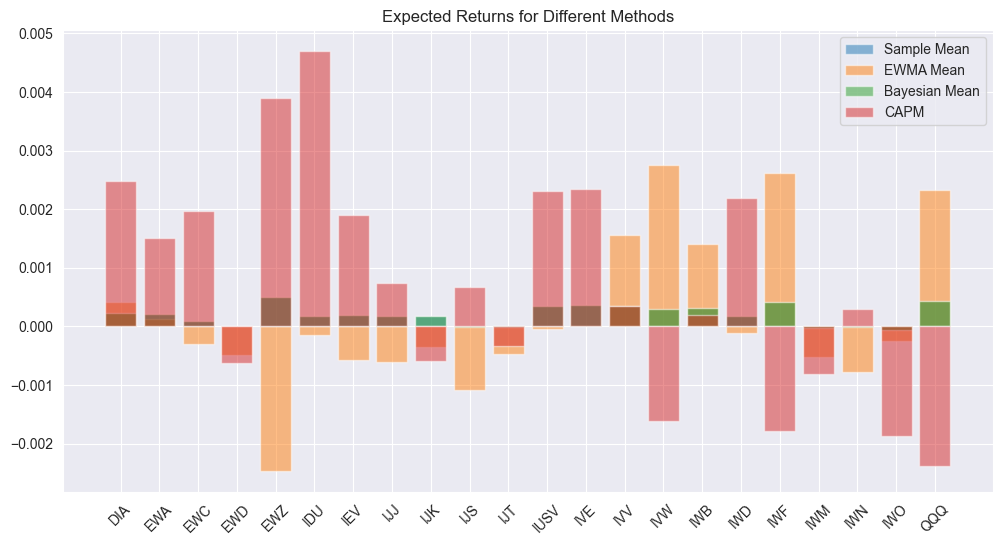

In [8]:
import numpy as np
import cvxpy as cp
import pandas as pd
from sklearn.linear_model import LinearRegression

def optimize_portfolio_weights(expected_returns):
    """Solve the portfolio optimization problem using convex programming."""
    M = len(expected_returns)
    w_direct_var = cp.Variable(M)
    constraints_direct = [cp.sum(w_direct_var) == 1, w_direct_var >= 0, w_direct_var <= 0.1]
    objective_direct = cp.Maximize(expected_returns @ w_direct_var)
    prob_direct = cp.Problem(objective_direct, constraints_direct)
    prob_direct.solve()
    return w_direct_var.value

# Optimize portfolio weights for each method
weights_sample = optimize_portfolio_weights(expected_returns_sample)
weights_ewma = optimize_portfolio_weights(expected_returns_ewma)
weights_bayesian = optimize_portfolio_weights(expected_returns_bayesian)
weights_capm = optimize_portfolio_weights(expected_returns_capm)

# Display results
df_results = pd.DataFrame({
    "Sample Mean": weights_sample,
    "EWMA Mean": weights_ewma,
    "Bayesian Mean": weights_bayesian,
    "CAPM": weights_capm
}, index=[f"Asset {i+1}" for i in range(Y_train.shape[1] - 1)])

print(df_results)

# Plot the expected returns for each method
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(funds[:-1], expected_returns_sample, alpha=0.5, label='Sample Mean')
plt.bar(funds[:-1], expected_returns_ewma, alpha=0.5, label='EWMA Mean')
plt.bar(funds[:-1], expected_returns_bayesian, alpha=0.5, label='Bayesian Mean')
plt.bar(funds[:-1], expected_returns_capm, alpha=0.5, label='CAPM')
plt.xticks(rotation=45)
plt.legend()
plt.title('Expected Returns for Different Methods')

# print the total return for each method
total_return_sample = np.sum(weights_sample * Y_test[0, :-1])
total_return_ewma = np.sum(weights_ewma * Y_test[0, :-1])
total_return_bayesian = np.sum(weights_bayesian * Y_test[0, :-1])
total_return_capm = np.sum(weights_capm * Y_test[0, :-1])

print(f'Total Return (Sample Mean): {total_return_sample:.4f}')
print(f'Total Return (EWMA Mean): {total_return_ewma:.4f}')
print(f'Total Return (Bayesian Mean): {total_return_bayesian:.4f}')
print(f'Total Return (CAPM): {total_return_capm:.4f}')

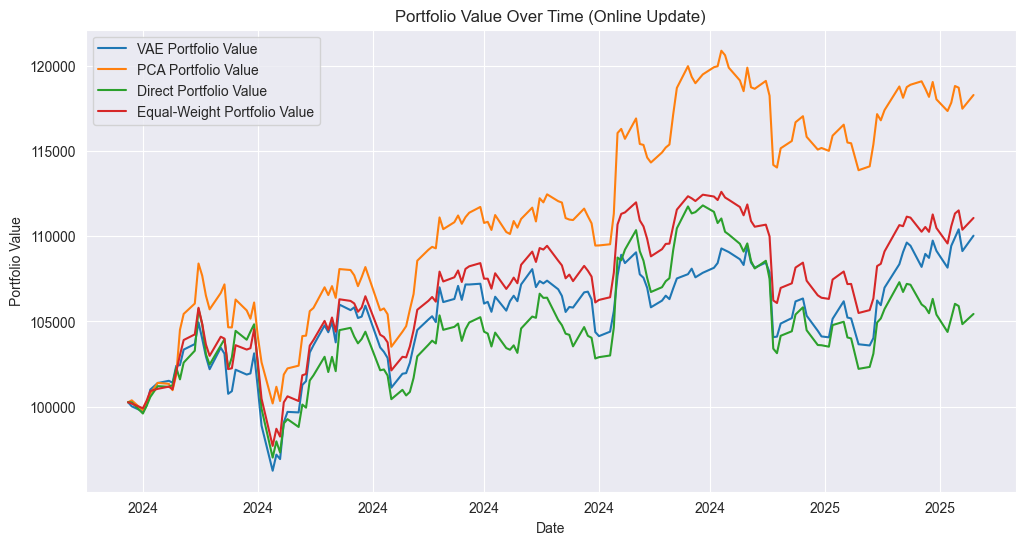

In [9]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Step 6: Constant Equal Weight Portfolio
equal_weights = np.ones(M) / M

# Step 7: Online Portfolio Learning and Simulation (VAE, PCA, Direct Optimization)
initial_investment = 100000
portfolio_value_vae = [initial_investment]
portfolio_value_pca = [initial_investment]
portfolio_value_direct = [initial_investment]
portfolio_value_constant = [initial_investment]

transaction_costs = 0.001  # 0.1% per transaction

expected_returns = sample_mean(Y_train)
optimal_weights = optimize_portfolio_weights(expected_returns)
w_direct_var = cp.Variable(len(expected_returns))
constraints_direct = [cp.sum(w_direct_var) == 1, w_direct_var >= 0, w_direct_var <= 0.1]


holdings_vae = initial_investment * optimal_weights  # Start with direct weights (can be pretrained VAE weights)
holdings_pca = initial_investment * optimal_weights
holdings_direct = initial_investment * optimal_weights
holdings_constant = initial_investment * optimal_weights

for t in range(Y_test.shape[0]):
    y_t_new = Y_test_tensor[t]

    # ---- VAE Online Update ----
    mu_new, logvar_new = encoder(y_t_new)
    std_new = torch.exp(0.5 * logvar_new)
    eps_new = torch.randn_like(std_new)
    z_t_new = mu_new + std_new * eps_new
    s_t_new = torch.softmax(z_t_new, dim=0)

    y_hat_new = torch.matmul(A, s_t_new)
    recon_loss_new = nn.MSELoss()(y_hat_new, y_t_new)
    kld_loss_new = -0.5 * torch.sum(1 + logvar_new - mu_new.pow(2) - logvar_new.exp())
    loss_new = recon_loss_new + kld_loss_new * 1e-4

    optimizer.zero_grad()
    loss_new.backward()
    optimizer.step()

    with torch.no_grad():
        A.copy_(A.clamp(min=0))

    expected_factor_returns_vae_new = s_t_new.detach().numpy()
    expected_returns_vae_new = A.detach().numpy() @ expected_factor_returns_vae_new

    # VAE Portfolio Rebalance
    prob_vae = cp.Problem(cp.Maximize(expected_returns_vae_new @ w_direct_var), constraints_direct)
    prob_vae.solve()
    w_vae = w_direct_var.value
    holdings_vae = np.sum(holdings_vae * (1 + Y_test[t])) * w_vae

    # PCA Portfolio Rebalance
    scores_pca_new = pca.transform(y_t_new.unsqueeze(0).numpy())
    expected_returns_pca_new = components_pca @ scores_pca_new.flatten()
    prob_pca = cp.Problem(cp.Maximize(expected_returns_pca_new @ w_direct_var), constraints_direct)
    prob_pca.solve()
    w_pca = w_direct_var.value
    holdings_pca = np.sum(holdings_pca * (1 + Y_test[t])) * w_pca

    # Direct Optimization Portfolio Rebalance
    expected_returns_direct_new = Y_test[:t+1].mean(axis=0)
    prob_direct = cp.Problem(cp.Maximize(expected_returns_direct_new @ w_direct_var), constraints_direct)
    prob_direct.solve()
    holdings_direct = np.sum(holdings_direct * (1 + Y_test[t])) * w_direct_var.value

    # Constant Portfolio (no rebalancing)
    holdings_constant = np.sum(holdings_constant * (1 + Y_test[t])) * equal_weights

    # Track portfolio values
    portfolio_value_vae.append(np.sum(holdings_vae))
    portfolio_value_pca.append(np.sum(holdings_pca))
    portfolio_value_direct.append(np.sum(holdings_direct))
    portfolio_value_constant.append(np.sum(holdings_constant))

# Step 8: Plot Portfolio Values Over Time
plt.figure(figsize=(12, 6))
plt.plot(dates_test, portfolio_value_vae[1:], label='VAE Portfolio Value')
plt.plot(dates_test, portfolio_value_pca[1:], label='PCA Portfolio Value')
plt.plot(dates_test, portfolio_value_direct[1:], label='Direct Portfolio Value')
plt.plot(dates_test, portfolio_value_constant[1:], label='Equal-Weight Portfolio Value')
plt.title('Portfolio Value Over Time (Online Update)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)

# Format the x-axis with years
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.show()

## Performance Evaluation

In [10]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Use Y_train for reconstruction evaluation if applicable
Y_hat_train = s_t_array @ A_trained.T  # Shape: [T_train, M]
mse_train = mean_squared_error(Y_train.flatten(), Y_hat_train.flatten())
print(f'Reconstruction MSE (VAE, Train Set): {mse_train:.6f}')

# Calculate explained variance ratio on training data
total_variance_train = np.var(Y_train, ddof=1)
residuals_train = Y_train - Y_hat_train
residual_variance_train = np.var(residuals_train, ddof=1)
explained_variance_ratio_train = 1 - (residual_variance_train / total_variance_train)
print(f'Explained Variance Ratio (VAE, Train Set): {explained_variance_ratio_train:.4f}')

# PCA reconstruction and explained variance on the full data Y
from sklearn.decomposition import PCA

pca = PCA(n_components=N)
pca.fit(Y_train)
Y_pca_train = pca.transform(Y_train)
Y_pca_reconstructed_train = pca.inverse_transform(Y_pca_train)

mse_pca_train = mean_squared_error(Y_train.flatten(), Y_pca_reconstructed_train.flatten())
explained_variance_pca_train = np.sum(pca.explained_variance_ratio_)
print(f'PCA Reconstruction MSE (Train Set): {mse_pca_train:.6f}')
print(f'PCA Explained Variance Ratio (Train Set): {explained_variance_pca_train:.4f}')

Reconstruction MSE (VAE, Train Set): 0.081834
Explained Variance Ratio (VAE, Train Set): -221.2656
PCA Reconstruction MSE (Train Set): 0.000007
PCA Explained Variance Ratio (Train Set): 0.9598


### Performance Metrics

In [11]:
def calculate_performance_metrics(portfolio_values, risk_free_rate=0.0):
    import pandas as pd
    portfolio_values = pd.Series(portfolio_values)
    
    # Calculate daily returns from portfolio values
    returns = portfolio_values.pct_change().dropna()
    
    # Annualized metrics
    mean_return = returns.mean() * 252  # Annualized
    volatility = returns.std() * np.sqrt(252)  # Annualized
    sharpe_ratio = (mean_return - risk_free_rate) / volatility
    
    # Cumulative return (final portfolio value relative to the initial)
    cumulative_return = (portfolio_values.iloc[-1] / portfolio_values.iloc[0]) - 1
    
    # Max Drawdown: The largest peak-to-trough decline in portfolio value
    running_max = portfolio_values.cummax()
    drawdown = (portfolio_values - running_max) / running_max
    max_drawdown = drawdown.min()
    
    return {
        'Mean Return': mean_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Cumulative Return': cumulative_return,
        'Max Drawdown': max_drawdown
    }

# Calculate performance metrics for each portfolio
metrics_vae = calculate_performance_metrics(portfolio_value_vae[1:])
metrics_pca = calculate_performance_metrics(portfolio_value_pca[1:])
metrics_direct = calculate_performance_metrics(portfolio_value_direct[1:])
metrics_constant = calculate_performance_metrics(portfolio_value_constant[1:])

# Display metrics in a DataFrame
df_metrics = pd.DataFrame(
    [metrics_vae, metrics_pca, metrics_direct, metrics_constant], 
    index=['VAE Portfolio', 'PCA Portfolio', 'Direct Portfolio', 'Equal-Weight Portfolio']
)
print(df_metrics)

                        Mean Return  Volatility  Sharpe Ratio  Cumulative Return  Max Drawdown
VAE Portfolio              0.162057    0.147249      1.100567           0.097465     -0.082904
PCA Portfolio              0.280595    0.153242      1.831060           0.179787     -0.075728
Direct Portfolio           0.094537    0.159218      0.593759           0.051678     -0.085760
Equal-Weight Portfolio     0.176258    0.139483      1.263652           0.107847     -0.076616


## Factor Analysis

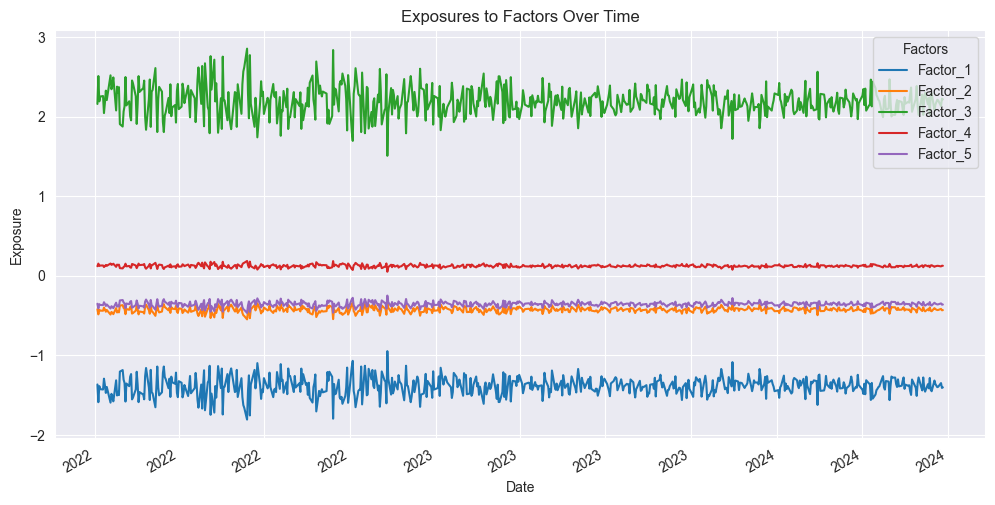

In [12]:
df_A = pd.DataFrame(A_trained, index=funds, columns=[f'Factor_{i + 1}' for i in range(N)])
df_s_t = pd.DataFrame(s_t_array, index=dates_train, columns=[f'Factor_{i + 1}' for i in range(N)])
import matplotlib.pyplot as plt
import seaborn as sns

df_s_t.plot(figsize=(12, 6))
plt.title('Exposures to Factors Over Time')
plt.xlabel('Date')
plt.ylabel('Exposure')
plt.legend(title='Factors')
plt.grid(True)

plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.show()